# 모듈 로드

In [1]:
import numpy as np
import pandas as pd
import warnings
import gc
from tqdm import tqdm_notebook as tqdm
import lightgbm as lgb
from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import roc_auc_score
warnings.filterwarnings("ignore")
gc.enable()
sns.set()

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

# 데이터 로드

In [3]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train.shape, test.shape

((200000, 202), (200000, 201))

In [4]:
col_list = train.columns[2:]

# Split into Pb and Pv

In [5]:
df_test = test.drop(['ID_code'], axis=1).values

unique_samples = []
unique_count = np.zeros_like(df_test)
for feature in tqdm(range(df_test.shape[1])):
    _, index_, count_ = np.unique(df_test[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1

# Samples which have unique values are real the others are fake
real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print(len(real_samples_indexes))
print(len(synthetic_samples_indexes))


100000
100000


In [8]:
df_test_real = df_test[real_samples_indexes].copy()

generator_for_each_synthetic_sample = []
# Using 20,000 samples should be enough. 
# You can use all of the 100,000 and get the same results (but 5 times slower)
for cur_sample_index in tqdm(synthetic_samples_indexes[:20000]):
    cur_synthetic_sample = df_test[cur_sample_index]
    potential_generators = df_test_real == cur_synthetic_sample

    # A verified generator for a synthetic sample is achieved
    # only if the value of a feature appears only once in the
    # entire real samples set
    features_mask = np.sum(potential_generators, axis=0) == 1
    verified_generators_mask = np.any(potential_generators[:, features_mask], axis=1)
    verified_generators_for_sample = real_samples_indexes[np.argwhere(verified_generators_mask)[:, 0]]
    generator_for_each_synthetic_sample.append(set(verified_generators_for_sample))

In [35]:
public_LB = generator_for_each_synthetic_sample[0]
for x in tqdm(generator_for_each_synthetic_sample):
    if public_LB.intersection(x):
        public_LB = public_LB.union(x)

private_LB = generator_for_each_synthetic_sample[1]
for x in tqdm(generator_for_each_synthetic_sample):
    if private_LB.intersection(x):
        private_LB = private_LB.union(x)
        
print(len(public_LB))
print(len(private_LB))


50000
50000


In [6]:
# np.save('./data_temp/public_LB', list(public_LB))
# np.save('./data_temp/private_LB', list(private_LB))

In [6]:
pb_idx = np.load('./data_temp/public_LB.npy')
pv_idx = np.load('./data_temp/private_LB.npy')

# EDA with public and private Data

In [7]:
train_0 = train[train.target == 0]
train_1 = train[train.target == 1]

In [8]:
test_real = test.iloc[real_samples_indexes]
test_synthetic = test.iloc[synthetic_samples_indexes]

In [9]:
test_pb = test.iloc[pb_idx].sort_index()
test_pv = test.iloc[pv_idx].sort_index()

In [10]:
data = train.append(test_real)

In [166]:
unique_df = pd.DataFrame(col_list, columns=['feature'])
unique_df['pb_nunique'] = test_pb[col_list].nunique(axis=0).values
unique_df['pv_nunique'] = test_pv[col_list].nunique(axis=0).values
unique_df['te_nunique'] = test_real[col_list].nunique(axis=0).values
unique_df['tr_nunique'] = train[col_list].nunique(axis=0).values
unique_df['tr_0_nunique'] = train_0.iloc[:20000][col_list].nunique(axis=0).values
unique_df['tr_1_nunique'] = train_1[col_list].nunique(axis=0).values
unique_df['data_nunique'] = data[col_list].nunique(axis=0).values

In [139]:
def get_intersections_nunique(data1, data2, col_list):
    result = []
    for col in tqdm(col_list):
        result.append(int(np.isin(data1[col].unique(), data2[col].unique()).sum()))
    
    return result

In [140]:
unique_df['intersection_pb_pv'] = get_intersections_nunique(test_pb, test_pv, col_list)
unique_df['intersection_te_tr'] = get_intersections_nunique(test_real, train.iloc[:100000], col_list)

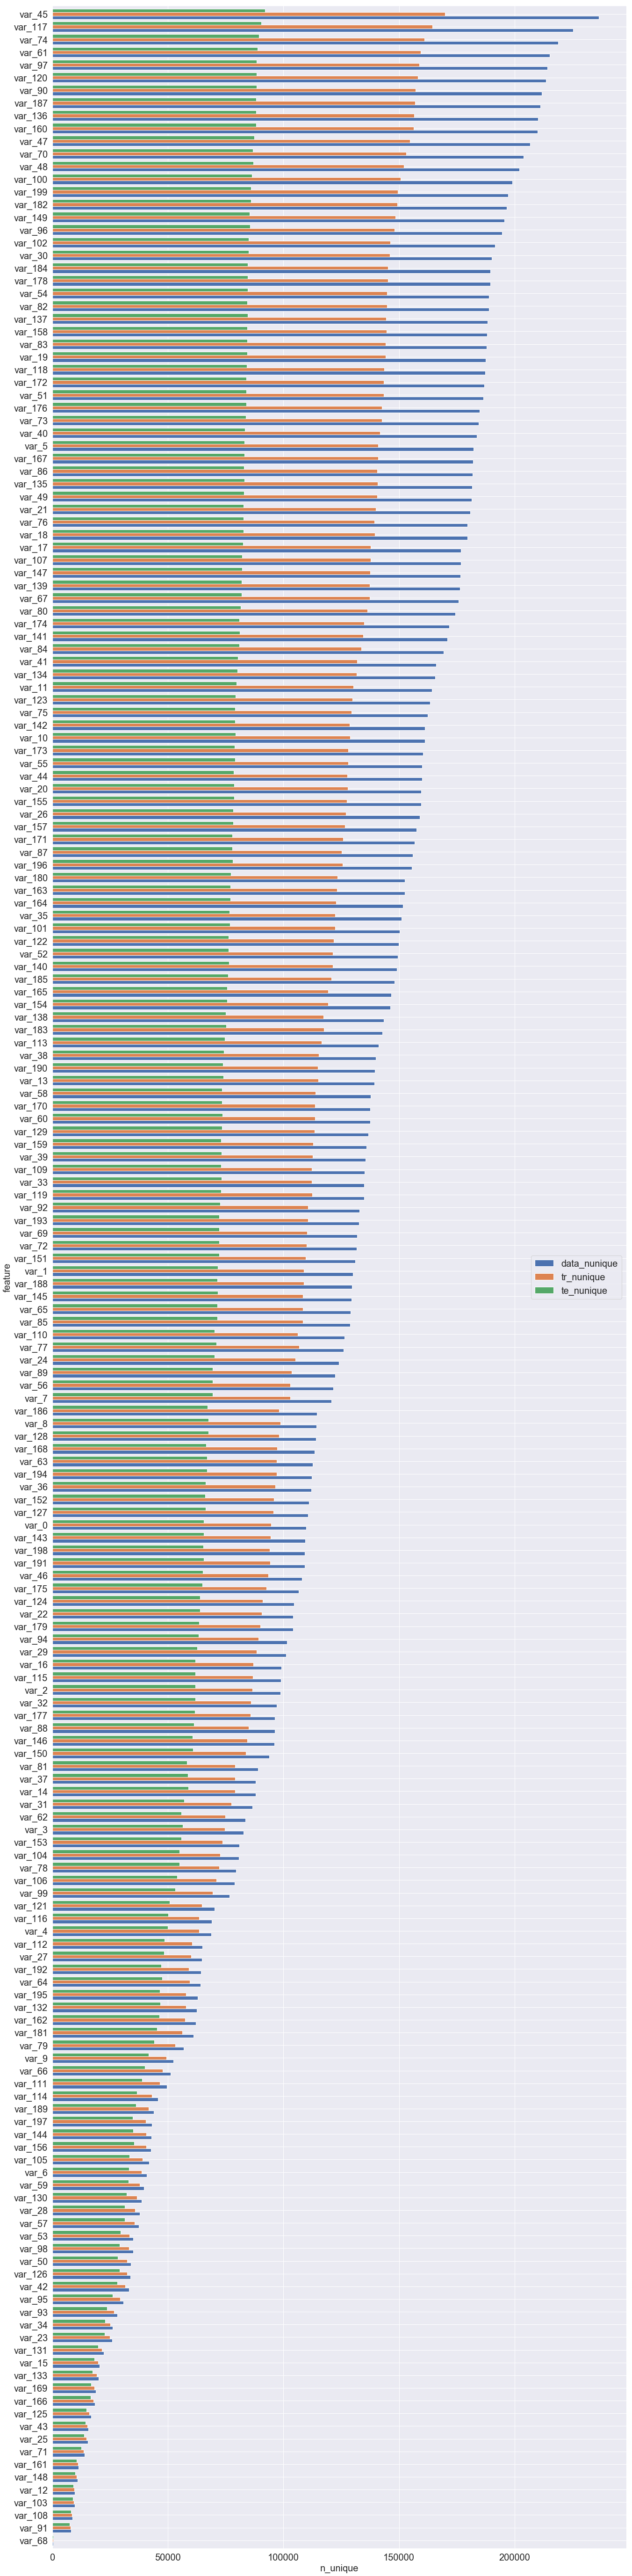

In [168]:
unique_df = unique_df.sort_values('data_nunique').reset_index(drop=True)
unique_df[['data_nunique', 'tr_nunique', 'te_nunique']].plot(kind='barh' ,figsize=(22, 100), fontsize=20, width=0.8)
plt.yticks(unique_df.index, unique_df['feature'].values)
plt.xlabel('n_unique', fontsize=20)
plt.ylabel('feature', fontsize=20)
plt.legend(loc='center right', fontsize=20)

In [163]:
np.any(np.array([[True, True, False], 
                 [False, False, False],
                 [False, False ,True]]), axis=1)

array([ True, False,  True])

# Find 0 and 1 Using Unique Split
* target = 1 에만 존재
* target = 0 에만 존재
* target - 0 and 1 에 존재

In [510]:
target_dist = train[['ID_code']]

for col in tqdm(col_list):
    target_0 = set(train_0[col].unique())
    target_1 = set(train_1[col].unique())
    target_0_and_1 = target_0.intersection(target_1)
    target_0 = target_0.difference(target_0_and_1)
    target_1 = target_1.difference(target_0_and_1)

    target_dist[col] = train[col].isin(target_0) * 1 + train[col].isin(target_1) * 2 + train[col].isin(target_0_and_1) * 3

In [976]:
col = 'var_69'
target_0 = set(train_0[col].unique())
target_1 = set(train_1[col].unique())
target_0_and_1 = target_0.intersection(target_1)
target_0 = target_0.difference(target_0_and_1)
target_1 = target_1.difference(target_0_and_1)

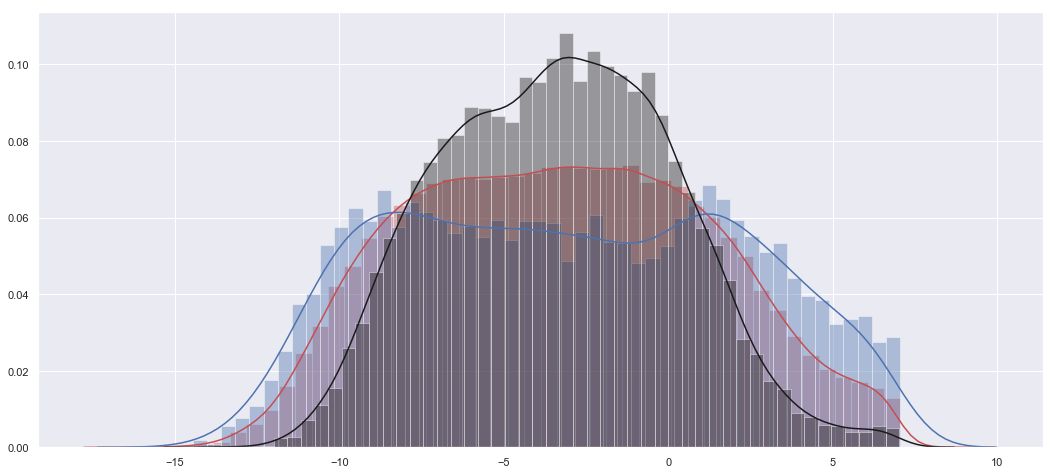

In [977]:
plt.figure(figsize=(18, 8))
sns.distplot(list(target_0), color='r', bins=50)
sns.distplot(list(target_1), color='b', bins=50)
sns.distplot(list(target_0_and_1), color='k', bins=50)

In [557]:
def get_values_0(data):
    return data.value_counts().loc[[1,3]]

In [558]:
def get_values_1(data):
    return data.value_counts().loc[[2,3]]

In [1115]:
def get_values(data):
    return data.value_counts().loc[[2,3]]

In [562]:
target_values_0 = target_dist[train.target == 0].apply(get_values_0, axis=1)

In [559]:
target_values_1 = target_dist[train.target == 1].apply(get_values_1, axis=1)

In [1119]:
train_1.shape

(20098, 202)

In [1117]:
bbiggu_idx.__len__()

3374

In [1120]:
20098 - 3374

16724

In [1118]:
target_dist.iloc[bbiggu_idx][col_list].apply(get_values, axis=0).T / 3374

,2,3
var_0,0.223177,0.776823
var_1,0.298755,0.701245
var_2,0.178423,0.821577
var_3,0.129520,0.870480
var_4,0.095732,0.904268
var_5,0.517190,0.482810
var_6,0.036455,0.963545
var_7,0.272377,0.727623
var_8,0.252519,0.747481
var_9,0.057795,0.942205


In [1121]:
target_dist.iloc[tt][col_list].apply(get_values, axis=0).T / 16724

,2,3
var_0,0.256039,0.743961
var_1,0.322112,0.677888
var_2,0.210835,0.789165
var_3,0.136451,0.863549
var_4,0.098780,0.901220
var_5,0.525652,0.474348
var_6,0.046341,0.953659
var_7,0.271406,0.728594
var_8,0.247489,0.752511
var_9,0.061947,0.938053


In [573]:
target_values_0.loc[normal_idx].head()

,1,3
0,151,49
2,148,52
4,150,50
5,156,44
7,149,51


In [574]:
target_values_1.loc[bbiggu_idx].head()

,2,3
142,58,142
207,63,137
301,54,146
348,58,142
391,61,139


In [1122]:
target_values_1.loc[tt].head()

,2,3
13,53,147
29,53,147
63,70,130
65,61,139
71,63,137


## common feature encoding

In [880]:
train[train.pred > 0.76].target.value_counts()

1    2104
0     161
Name: target, dtype: int64

In [1003]:
new_train = train[train.pred < 0.1]
new_train_temp = new_train[['ID_code']]
for col in tqdm(col_list):
    new_train_temp[col] = new_train[col].map(train[col].value_counts())#.isin(train[train.pred > 0.1][col]) * 1

In [1005]:
new_train_temp = new_train_temp != 1

In [1098]:
for col in col_list:
    print(new_train[col][new_train_temp[col]].isin(train.iloc[tt][col].values).sum(), end=' ')

652 895 525 380 274 1624 105 784 734 164 1314 1354 6 1048 420 22 543 1535 1597 1754 1338 1602 596 51 838 18 1337 235 89 595 1772 459 552 973 35 1176 701 427 1041 1006 1654 1354 75 18 1303 2461 644 1970 1917 1644 67 1695 1111 70 1675 1369 813 81 974 84 1007 2088 394 695 226 903 131 1553 1 930 1913 24 942 1637 2160 1341 1615 887 325 184 1557 423 1789 1695 1461 927 1570 1288 524 804 2040 11 920 53 531 63 1765 2124 80 322 1904 1214 1741 10 361 130 371 1553 4 1007 911 153 257 1081 128 536 270 2279 1681 933 2063 277 1177 1416 615 29 62 690 728 999 85 36 207 48 1417 1589 2066 1742 1133 1572 1168 1470 1374 646 121 940 516 1565 12 1813 491 941 695 344 1137 1349 94 1297 1729 993 1974 11 213 1184 1227 1082 24 1631 690 14 1006 1290 1710 1343 1474 629 1701 540 1719 583 1214 229 1808 1064 1742 1112 708 2032 915 96 1011 651 220 995 678 202 1245 92 639 1860 

In [1113]:
tt = bbiggu[(bbiggu.bbiggu == 0) & (bbiggu.target == 1)].index

In [1082]:
new_train[col][new_train_temp[col]].isin(train[train.pred > 0.1][col].values).sum()

0

In [1078]:
train[train.pred > 0.1][col].values.shape

(52067,)

In [1086]:
train[train.pred > 0.1].target.value_counts()

0    35343
1    16724
Name: target, dtype: int64

In [1067]:
new_train[col][new_train_temp[col]]

8         13.9307
14        17.2611
16        15.1325
19        15.1828
20         6.8930
36         7.6387
41         9.0991
42        15.3908
46        13.2053
61        15.1206
70        16.1071
111        5.3849
134       15.7183
142        8.6358
188       13.6795
191        7.1691
192        8.6202
201       11.9933
205        7.2906
210       17.6616
213        4.0273
222        6.7969
243       14.2968
246        6.8264
269        5.3743
280        6.7433
286        6.7212
303        7.5541
320       14.3081
359        8.2800
360       16.3601
362       13.9019
363       18.1084
372        9.7591
382       13.3667
383       10.4148
392       11.9591
425        7.2020
428        6.3114
435        8.7952
443        4.8572
446       15.7714
460       13.0392
476        9.1532
480       10.3345
481       11.2378
487        6.8469
495       13.0091
497        8.1661
501       16.1426
504        8.8720
517       13.0045
519       15.0649
546        6.8613
547        6.2609
565       

In [ ]:
train

In [1000]:
col = 'var_0'

new_train[col][new_train_temp[col]]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

In [979]:
new_train_temp['target'] = new_train.target

In [984]:
new_train_temp.loc[normal_idx].iloc[0].value_counts(dropna=False)

1          49
2          39
3          34
4          17
5          14
8           8
6           6
7           5
14          3
9           3
11          2
12          2
13          2
15          2
21          2
29          2
10          2
573         1
46          1
18          1
23          1
26          1
32          1
35          1
36          1
train_0     1
0           1
Name: 0, dtype: int64

In [989]:
new_train_temp.loc[bbiggu_idx].iloc[4].value_counts(dropna=False)

1            57
2            46
3            33
4            15
5             9
6             6
7             5
8             4
10            4
14            3
12            3
13            3
16            2
9             1
37            1
44            1
11            1
38            1
train_391     1
17            1
19            1
56            1
725           1
24            1
32            1
Name: 391, dtype: int64

In [713]:
col = 'var_2'
value = 12.608

In [687]:
unique_hash[col]

,pred
var_2,
2.1171,[0.021614413433175397]
2.1693,[0.0364499015274307]
2.3134,[0.008510076622578433]
2.5825,[0.1590898399276609]
2.6150,[0.1361209297946565]
2.7892,[0.017308517885757747]
2.8982,[0.012604828609076985]
2.9143,[0.258797995383284]
2.9462,"[0.015015024919798082, 0.27107827428407644]"


In [680]:
train[train[col] == value]

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,pred


In [525]:
target_values = pd.DataFrame(columns=[3,2])

In [526]:
for i in tqdm(range((train.target == 1).sum())):
    target_values.append(target_dist[train.target == 1].iloc[i].value_counts().to_frame().T[[3,2]])

KeyboardInterrupt: 

# Find 0/1 Using Unique Value

In [210]:
unique_df = train[['ID_code']]

for col in tqdm(col_list):
    temp = train[col].value_counts().to_frame()
    
    unique_df[col] = train[col].isin(np.around(temp[temp[col] > 1].index, 4).tolist())


In [220]:
train['pred'] = pd.read_csv('./data_temp/bbiggu_1.csv').pred

In [426]:
bbiggu['target'] = train.target

In [427]:
bbiggu[bbiggu.target == 0].sort_values('pred')

,ID_code,pred,bbiggu,fold,target
116261,train_116261,0.000306,0,4,0
143611,train_143611,0.000360,0,1,0
108444,train_108444,0.000432,0,1,0
191149,train_191149,0.000483,0,3,0
35412,train_35412,0.000487,0,3,0
111325,train_111325,0.000508,0,5,0
97185,train_97185,0.000551,0,3,0
50908,train_50908,0.000556,0,4,0
114767,train_114767,0.000571,0,4,0
132257,train_132257,0.000574,0,2,0


In [444]:
normal_idx = bbiggu[(bbiggu.bbiggu == 0) & (bbiggu.pred < 0.1)].index.tolist()

In [400]:
bbiggu = pd.read_csv('./data_temp/bbiggu_1.csv')

In [419]:
bbiggu_idx = bbiggu[bbiggu.bbiggu == 1].index.tolist()

In [283]:
unique_df.head(5)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,True,True,True,True,True,False,True,True,True,False,True,True,True,False,True,True,False,True,False,False,True,True,True,True,False,True,True,True,True,True,False,True,True,True,True,True,True,True,False,False,True,True,True,True,False,False,False,False,True,True,True,False,False,True,False,True,False,True,True,True,True,False,True,True,True,False,True,False,True,False,True,True,False,False,False,True,False,True,True,True,False,True,False,True,True,True,True,True,True,False,False,True,True,True,True,True,False,False,True,True,False,True,True,True,True,False,True,False,True,True,True,True,True,False,True,True,True,False,True,False,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,False,True,False,True,True,True,False,True,True,False,True,True,True,True,True,False,True,True,True,False,True,True,True,True,False,True,True,False,True,True,True,True,True,True,True,False,True,True,True,True,True,True
1,train_1,True,True,True,False,True,False,True,True,True,True,True,False,True,True,True,True,True,False,False,False,False,False,False,True,True,False,False,True,True,False,True,True,True,True,True,True,True,True,False,True,True,False,True,True,True,False,False,True,False,True,True,False,True,True,False,False,True,True,True,True,True,False,True,True,True,True,True,True,True,False,False,True,True,False,True,False,False,False,True,True,True,False,False,False,True,True,False,True,True,False,False,True,False,True,True,True,False,False,True,True,False,True,True,True,False,True,True,True,True,False,True,True,True,False,True,True,True,False,False,False,True,True,True,True,False,True,True,True,True,False,True,False,True,True,True,True,False,True,True,False,True,True,False,True,True,True,True,True,True,False,False,False,True,True,False,True,True,True,True,True,True,True,True,False,False,True,True,False,True,True,False,False,False,False,False,True,False,True,False,False,True,True,False,True,False,True,True,False,True,True,True,True,True,False,False,True,True,True,False,False
2,train_2,True,False,True,True,True,True,True,True,False,True,False,False,True,True,True,True,True,False,True,True,True,False,True,True,False,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,False,True,False,False,True,True,True,True,True,True,False,False,True,True,True,True,True,False,True,True,True,True,Tr

In [445]:
unique_df.iloc[normal_idx][col_list].sum(axis=1)

0         147
2         158
4         132
5         138
7         137
8         145
9         143
10        147
11        150
12        145
14        149
16        139
17        129
18        140
19        140
20        132
21        146
22        132
23        137
24        143
25        139
27        146
28        150
30        143
31        146
32        145
34        142
35        158
36        146
37        137
38        138
39        156
40        140
41        149
42        146
43        138
44        138
46        140
47        142
48        146
49        135
50        139
52        139
53        135
54        148
55        145
56        145
57        136
58        138
59        143
61        134
62        137
64        136
66        138
67        142
68        137
69        159
70        150
73        138
77        141
78        141
80        146
81        145
82        144
83        146
85        146
86        145
87        149
89        147
91        143
92        153
93    

In [438]:
unique_df.iloc[bbiggu_idx][col_list].sum(axis=1)

142       142
207       140
301       147
348       139
391       139
410       138
454       148
487       149
507       147
514       146
525       132
576       139
592       141
671       138
684       137
698       136
724       143
727       144
733       151
752       145
774       133
808       135
821       144
954       150
1114      146
1116      148
1180      147
1218      145
1281      147
1312      131
1327      139
1331      145
1333      140
1441      147
1588      142
1748      137
1749      152
1761      154
1774      138
1835      136
1858      156
1908      142
2011      135
2016      145
2093      149
2126      135
2211      144
2227      146
2259      151
2301      146
2392      137
2411      151
2436      135
2458      133
2497      138
2589      139
2597      136
2682      147
2764      147
2765      130
2776      139
2839      140
2920      145
3072      141
3091      139
3120      138
3155      136
3187      147
3219      144
3242      147
3253      145
3328  

In [484]:
idx = 0
temp = train[col_list].iloc[idx][unique_df[col_list].iloc[idx]].to_frame().reset_index()
temp.columns = ['columns', 'values']
temp.apply(func, axis=1)

0                                                                                                                                                                                                                                                                                                                                                                                        [0.014813241000685606, 0.00795077396266417, 0.13401960518678818, 0.2776701881012294, 0.052468373898450715, 0.0067832250485333504]
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                             [0.014813241000685606, 0.060932

In [421]:
result = []
for idx in tqdm(bbiggu_idx):
    temp = train[col_list].iloc[idx][unique_df[col_list].iloc[idx]].to_frame().reset_index()
    temp.columns = ['columns', 'values']
    result.append(temp.apply(func, axis=1).mean())

In [424]:
np.min(result)

0.05898118082283159

In [481]:
def func(data):
    return unique_hash[data['columns']].loc[data['values']].values[0]

In [246]:
def func(data):
    return data.values.tolist()
#     return data

In [258]:
unique_hash = {}
for col in tqdm(col_list):
    unique_hash[col] = train[[col, 'pred']].groupby(col)['pred'].agg(func).to_frame()

In [281]:
unique_hash['var_4'].loc[12.1450]

pred    [0.3299668754114549, 0.17765020725242306, 0.8009683448321224, 0.30543235017909004, 0.10334504817290778]
Name: 12.145, dtype: object

In [268]:
np.mean(unique_hash['var_0'].loc[8.9255].values[0])

0.08228423453305857

In [226]:
col = 'var_0'
temp = train[col].value_counts().to_frame()
temp[temp[col] > 1]

,var_0
10.6829,11
13.0656,11
8.6649,11
11.9590,10
11.2916,10
11.7837,10
10.7369,10
8.7260,10
9.5882,10
9.5114,10


In [180]:
col = 'var_0'
temp = train[col].value_counts().to_frame()
temp[temp[col] > 1].index

,var_0
15.0634,1
9.0488,1
14.1188,1
4.8706,1
13.5332,1
7.9473,1
6.7175,1
6.4192,1
6.3689,1
12.4560,1


In [191]:
col = 'var_1'

In [192]:
temp = train[col].value_counts().to_frame().reset_index()
temp = temp[temp['index'].isin(set(train_0[col].unique()).difference(set(train_1[col].unique())))]
temp[temp[col] > 1].shape

(41203, 2)

In [193]:
temp = train[col].value_counts().to_frame().reset_index()
temp = temp[temp['index'].isin(set(train_0[col].unique()).intersection(set(train_1[col].unique())))]
temp[temp[col] > 1].shape

(12702, 2)

In [185]:
temp[temp.var_0 > 1].shape

(40249, 2)

In [172]:
temp.shape

(94672, 2)

In [160]:
set(train.var_0.unique()).difference(set(test.var_0.unique()))

{2.8827,
 3.5702,
 4.875,
 5.875,
 5.0702,
 6.9846,
 6.4846,
 5.3125,
 6.625,
 5.5625,
 7.9375,
 13.0231,
 13.8433,
 15.6567,
 15.5231,
 16.2491,
 15.2808,
 16.5009,
 17.0634,
 18.875,
 19.0317,
 14.25,
 15.625,
 16.5625,
 17.5,
 18.6875,
 4.75,
 4.8125,
 6.125,
 7.625,
 7.4375,
 8.9375,
 8.125,
 8.3125,
 8.8125,
 8.625,
 9.625,
 9.125,
 9.4375,
 9.6875,
 8.5625,
 10.5625,
 10.625,
 10.0625,
 11.0,
 11.25,
 11.0625,
 12.1875,
 12.0,
 12.0625,
 12.4375,
 12.5625,
 13.625,
 13.0625,
 13.9375,
 13.3125,
 13.875,
 14.125,
 14.6875,
 14.0,
 14.875,
 14.3125,
 15.6875,
 15.75,
 15.3125,
 14.625,
 14.5,
 16.6875,
 16.0,
 16.4375,
 3.8998,
 3.7123,
 17.875,
 17.375,
 17.125,
 17.4375,
 17.8125,
 18.25,
 5.0873,
 4.0248,
 5.5873,
 5.1498,
 5.9623,
 6.9623,
 6.8373,
 6.1498,
 7.7123,
 3.2996,
 4.8621,
 5.0496,
 5.7996,
 5.6121,
 6.7996,
 6.2996,
 6.8621,
 6.4246,
 7.4871,
 7.1746,
 7.2996,
 7.7371,
 8.2996,
 8.3621,
 8.7996,
 9.2996,
 9.9246,
 10.8621,
 10.7371,
 10.6121,
 10.9246,
 10.7996,
 11

In [124]:
idxs = {}
for col in tqdm(col_list):
    temp = test_pb[col].value_counts().to_frame()
    temp = np.around(temp[temp[col] == 1].index, 4).tolist()
    idxs[col] = test_pb[test_pb[col].isin(temp)].index.tolist()

In [133]:
pred = pd.read_csv('./data/sub_without_bbiggu.csv').loc[test_pb.index]

In [139]:
test_pb.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
7,test_7,17.3035,-2.4212,13.3989,8.3998,11.0777,9.6449,5.9596,17.8477,-4.8068,7.4643,4.0355,1.6185,14.1455,9.2276,10.3202,15.1863,10.4344,-16.2784,20.4167,16.3993,26.0324,18.2594,5.8071,4.0316,19.0425,13.2969,-6.3679,0.1439,5.1571,4.2024,-7.6541,11.0271,-4.0223,14.8908,11.2465,12.2744,2.6117,3.7225,11.9105,7.4879,-1.0589,12.9685,9.9273,11.9615,9.5903,-11.6245,9.9861,-2.3604,29.7697,15.5135,12.7145,18.6272,-0.3277,6.4081,-4.0908,9.1192,16.5790,5.2576,-0.4040,9.5163,9.2034,-19.3891,1.3491,-1.2249,7.8745,-1.4398,3.6731,19.5793,5.0351,-4.0532,24.1029,0.4480,4.1605,30.3208,29.9375,2.7040,-13.5575,20.5463,7.5424,14.3924,3.8249,18.7879,-13.4008,-6.9739,3.5344,16.9480,2.0801,5.4255,10.8931,7.5485,-1.1905,7.1200,10.0399,11.7667,9.2020,-0.7176,12.5804,31.8321,1.7538,-0.7070,-22.7363,11.6984,18.0784,1.7108,9.2897,5.5384,13.0755,23.3108,14.1560,14.5899,5.5510,7.7358,5.2163,13.7452,1.5873,6.0762,4.9045,20.5785,-14.9020,7.3964,32.9594,8.5667,0.9854,11.8573,3.4626,12.0244,14.1143,-0.8310,-0.7450,15.3384,11.3860,1.0311,8.3112,7.4290,-3.6762,-11.7978,11.7961,1.1644,-3.2493,5.7673,9.8482,6.9077,15.8785,11.6216,7.9618,2.5143,14.5101,-0.0356,4.0720,-0.7705,17.7689,11.6995,4.3652,12.9432,8.2277,-2.9284,13.3862,-8.4828,28.2227,8.6334,33.2387,5.5475,5.0035,13.2442,-3.8513,9.9877,3.1809,-12.0160,0.7334,5.7269,2.5807,-1.2435,25.3933,6.0510,15.6766,12.1939,-1.3424,13.5346,-13.1117,2.0752,-0.3896,9.4374,-3.2351,9.3452,20.7098,0.9508,9.6602,-11.1847,15.7181,-1.0241,4.4676,4.4214,0.9303,1.4994,15.2648,-1.7931,6.5316,10.4855,23.4631,0.7283
17,test_17,9.0936,-8.7414,17.1160,6.0126,9.2144,-3.6761,4.6477,20.1053,1.7687,7.9974,1.4059,-4.8320,13.9907,4.6164,4.8209,14.3365,8.2884,-4.4573,8.2930,11.0580,9.4279,29.1249,7.7990,2.8724,8.2887,13.4910,9.3720,-0.2139,5.4569,6.7650,-20.9608,8.1488,-2.5007,21.5891,10.9957,7.2324,1.4785,6.5885,9.0633,-0.9529,-9.6313,8.4300,11.2006,11.8533,9.1231,-2.1911,12.9880,-4.5043,19.5127,19.6830,12.6179,28.1225,-6.0048,6.3516,-3.4252,10.0515,23.5727,5.5554,7.4315,8.9215,10.8569,-18.6546,4.2193,0.9861,4.9571,2.4452,4.5374,13.4026,5.0101,-3.0873,21.6605,0.9704,-3.3922,21.3826,25.0582,25.5802,-2.9256,15.3050,5.0315,13.8803,-0.1633,13.0824,-11.8412,3.4469,-3.0743,17.5884,3.0035,10.3797,3.6996,0.8397,-11.8526,6.9460,7.5807,10.4537,10.3685,-0.7281,16.2341,17.3218,2.1739,0.2978,3.6922,11.7575,36.2402,1.4822,11.7041,2.5428,5.8293,15.6129,14.4198,20.7810,-1.5919,5.7935,2.6232,10.9542,4.5107,0.3491,-0.0474,14.5762,-18.5012,7.6528,20.0021,13.6686,7.0526,11.7965,4.7428,12.55

In [145]:
unique_df = test_pb[['ID_code']]
for col in tqdm(col_list):
    temp = test_pb[col].value_counts().to_frame()
    temp = np.around(temp[temp[col] == 1].index, 4).tolist()
    unique_df[col] = test_pb[col].isin(temp)

In [158]:
pred.loc[72665]

ID_code    test_72665
target      0.0102378
Name: 72665, dtype: object

In [148]:
unique_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
7,test_7,True,False,True,False,False,True,False,True,True,False,True,False,False,True,False,False,True,True,True,False,True,True,True,True,True,False,True,False,False,False,True,True,True,True,False,True,False,True,True,True,True,True,False,False,True,True,True,True,True,False,False,True,False,False,True,True,True,False,False,False,True,True,True,False,False,False,True,True,False,True,False,False,True,True,True,False,True,True,False,True,True,True,False,True,True,False,True,False,False,False,True,False,False,True,False,False,True,True,False,False,True,False,True,False,True,True,True,True,False,False,False,True,False,True,True,False,True,True,False,True,True,True,True,True,True,False,False,False,True,True,False,False,False,False,True,True,True,True,False,True,True,True,True,False,False,True,True,False,False,True,False,False,True,True,False,False,True,False,True,True,True,False,False,True,True,True,False,False,False,False,True,True,True,False,True,False,True,True,True,True,False,False,True,True,False,True,True,False,False,False,True,False,False,True,True,False,True,True,True,True
17,test_17,True,True,False,True,True,True,False,True,False,False,True,False,False,True,False,False,True,True,True,True,True,True,False,False,True,False,True,False,False,False,True,False,True,True,False,True,False,True,True,True,True,True,False,False,True,True,True,True,True,False,True,True,True,False,True,True,True,False,True,False,True,True,True,True,True,True,True,True,False,False,True,False,True,True,True,False,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True,False,False,False,True,False,True,False,False,False,True,True,True,False,True,True,True,False,False,True,True,False,False,True,False,True,True,True,True,True,True,False,False,True,True,False,False,True,False,True,False,False,False,False,True,False,True,True,True,False,True,True,True,False,False,True,False,False,False,True,True,False,True,False,True,True,False,False,False,False,True,False,False,False,True,True,False,True,False,False,False,False,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,False,True,False,True,True,False,True
18,test_18,False,True,False,False,True,True,False,True,False,False,True,False,False,True,False,False,False,True,True,True,True,False,True,False,True,False,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,True,True,False,True,True,False,True,True,False,False,True,True,False,False

In [156]:
test_pb.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
7,test_7,17.3035,-2.4212,13.3989,8.3998,11.0777,9.6449,5.9596,17.8477,-4.8068,7.4643,4.0355,1.6185,14.1455,9.2276,10.3202,15.1863,10.4344,-16.2784,20.4167,16.3993,26.0324,18.2594,5.8071,4.0316,19.0425,13.2969,-6.3679,0.1439,5.1571,4.2024,-7.6541,11.0271,-4.0223,14.8908,11.2465,12.2744,2.6117,3.7225,11.9105,7.4879,-1.0589,12.9685,9.9273,11.9615,9.5903,-11.6245,9.9861,-2.3604,29.7697,15.5135,12.7145,18.6272,-0.3277,6.4081,-4.0908,9.1192,16.5790,5.2576,-0.4040,9.5163,9.2034,-19.3891,1.3491,-1.2249,7.8745,-1.4398,3.6731,19.5793,5.0351,-4.0532,24.1029,0.4480,4.1605,30.3208,29.9375,2.7040,-13.5575,20.5463,7.5424,14.3924,3.8249,18.7879,-13.4008,-6.9739,3.5344,16.9480,2.0801,5.4255,10.8931,7.5485,-1.1905,7.1200,10.0399,11.7667,9.2020,-0.7176,12.5804,31.8321,1.7538,-0.7070,-22.7363,11.6984,18.0784,1.7108,9.2897,5.5384,13.0755,23.3108,14.1560,14.5899,5.5510,7.7358,5.2163,13.7452,1.5873,6.0762,4.9045,20.5785,-14.9020,7.3964,32.9594,8.5667,0.9854,11.8573,3.4626,12.0244,14.1143,-0.8310,-0.7450,15.3384,11.3860,1.0311,8.3112,7.4290,-3.6762,-11.7978,11.7961,1.1644,-3.2493,5.7673,9.8482,6.9077,15.8785,11.6216,7.9618,2.5143,14.5101,-0.0356,4.0720,-0.7705,17.7689,11.6995,4.3652,12.9432,8.2277,-2.9284,13.3862,-8.4828,28.2227,8.6334,33.2387,5.5475,5.0035,13.2442,-3.8513,9.9877,3.1809,-12.0160,0.7334,5.7269,2.5807,-1.2435,25.3933,6.0510,15.6766,12.1939,-1.3424,13.5346,-13.1117,2.0752,-0.3896,9.4374,-3.2351,9.3452,20.7098,0.9508,9.6602,-11.1847,15.7181,-1.0241,4.4676,4.4214,0.9303,1.4994,15.2648,-1.7931,6.5316,10.4855,23.4631,0.7283
17,test_17,9.0936,-8.7414,17.1160,6.0126,9.2144,-3.6761,4.6477,20.1053,1.7687,7.9974,1.4059,-4.8320,13.9907,4.6164,4.8209,14.3365,8.2884,-4.4573,8.2930,11.0580,9.4279,29.1249,7.7990,2.8724,8.2887,13.4910,9.3720,-0.2139,5.4569,6.7650,-20.9608,8.1488,-2.5007,21.5891,10.9957,7.2324,1.4785,6.5885,9.0633,-0.9529,-9.6313,8.4300,11.2006,11.8533,9.1231,-2.1911,12.9880,-4.5043,19.5127,19.6830,12.6179,28.1225,-6.0048,6.3516,-3.4252,10.0515,23.5727,5.5554,7.4315,8.9215,10.8569,-18.6546,4.2193,0.9861,4.9571,2.4452,4.5374,13.4026,5.0101,-3.0873,21.6605,0.9704,-3.3922,21.3826,25.0582,25.5802,-2.9256,15.3050,5.0315,13.8803,-0.1633,13.0824,-11.8412,3.4469,-3.0743,17.5884,3.0035,10.3797,3.6996,0.8397,-11.8526,6.9460,7.5807,10.4537,10.3685,-0.7281,16.2341,17.3218,2.1739,0.2978,3.6922,11.7575,36.2402,1.4822,11.7041,2.5428,5.8293,15.6129,14.4198,20.7810,-1.5919,5.7935,2.6232,10.9542,4.5107,0.3491,-0.0474,14.5762,-18.5012,7.6528,20.0021,13.6686,7.0526,11.7965,4.7428,12.55

In [157]:
test_pb[test_pb.var_2 == 10.7782]

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
18,test_18,15.7875,0.1671,10.7782,3.8521,9.1190,11.0196,6.1113,18.4368,-1.0728,7.0586,-11.7156,-10.7639,13.8599,12.0673,4.3904,14.6607,7.5912,-16.2951,17.1345,2.2003,7.2735,15.8540,0.6809,3.3163,14.3670,13.7665,-9.7874,-2.2443,5.6784,5.5229,-1.5568,10.9440,-0.3326,22.1251,11.6341,3.6164,-0.2475,6.2732,12.9950,3.9204,-11.5693,4.7811,10.3083,11.1523,7.2018,16.8716,12.9467,-4.6112,3.5170,7.5735,12.4476,33.3176,-10.1811,6.6304,5.1383,14.5137,16.8122,7.1148,-5.1893,7.5383,17.8206,-24.6943,-0.1378,4.0670,7.2664,0.3495,7.6576,10.0866,5.0248,-8.3098,28.6920,0.8203,4.6334,19.6098,27.3233,24.0049,7.7879,15.6367,3.1580,15.3245,3.4079,13.1566,-5.5225,17.7289,0.0667,16.9446,2.1872,11.5791,10.4221,1.1777,-28.4432,7.1097,11.2444,10.2011,17.1149,0.0208,10.4529,20.4509,1.3389,-1.6754,-20.7810,17.4896,27.4262,1.6980,14.8031,3.1149,7.0228,20.3282,14.4266,19.1991,5.3033,7.8399,1.3332,16.2959,3.8614,3.0790,3.6750,37.3462,2.4197,-0.5003,31.331,12.7374,8.3291,-9.0132,4.5314,12.8825,12.3294,5.7900,2.3739,17.5709,11.0031,1.1307,9.6295,6.6325,-10.3339,4.8971,37.9160,30.5514,2.8800,3.9400,-0.4846,5.7032,13.6161,13.5469,6.7368,9.3147,4.0634,-6.6125,3.9087,-0.5970,14.8013,8.9762,5.6788,16.3560,4.7820,9.6727,12.5073,4.1835,23.0801,9.6168,16.7746,5.3468,4.8334,3.8233,-2.3192,30.4932,2.6502,-0.1112,3.4567,5.5454,0.3598,5.6640,5.0279,8.5583,6.5480,12.8568,-10.0698,13.5879,-0.546,0.0780,-4.0575,9.7363,9.2090,11.2027,8.2519,-0.9811,12.6881,-18.9585,17.7327,1.1853,6.7408,13.1753,0.2111,6.6279,19.2890,-0.0982,7.5500,9.3848,14.4007,11.2567
72665,test_72665,11.2722,0.6612,10.7782,9.8953,11.0544,-17.5271,4.5307,12.6304,3.4831,7.1554,-2.7568,-7.8191,13.7463,4.2536,7.9017,14.3313,7.5095,-13.0630,13.2534,15.9153,9.7430,26.7543,5.8563,2.6106,10.0241,13.9149,1.5741,-2.5756,4.9521,5.7204,4.7535,10.9839,-1.5607,18.1492,11.7898,3.6376,1.8042,4.6863,6.1894,0.4873,-8.1178,9.5003,10.4092,11.8765,7.2117,-4.4410,10.1714,-21.0461,12.0611,10.4479,12.4721,23.0503,-0.6618,5.9439,0.3823,1.9667,14.3786,5.7595,2.7231,9.0227,11.9789,-33.9928,1.4394,5.1219,6.0540,-3.5845,7.8350,10.3599,5.0210,-1.8110,11.1169,1.0050,2.9308,18.0680,15.4267,26.8155,16.1428,16.2128,7.1568,15.5868,18.0702,17.0994,-20.7929,-2.3289,-12.1923,12.5099,-13.1918,10.0600,7.9765,3.9492,-19.1825,6.8709,16.8789,10.5031,7.8552,-0.5261,0.1020,11.7110,2.2762,-4.8566,-23.3937,6.5531,40.0524,1.6299,13.8758,5.5109,10.8960,20.2572,14.4942,24.5852,6.0726,5.0418,4.9299,10.1936,1.6211,0.6282,2.8898,-3.7271,-7.9570,1.4176,6.917,13.0591,6.9803,4.2414,4.7751,12.5

In [150]:
test_pb.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
7,test_7,17.3035,-2.4212,13.3989,8.3998,11.0777,9.6449,5.9596,17.8477,-4.8068,7.4643,4.0355,1.6185,14.1455,9.2276,10.3202,15.1863,10.4344,-16.2784,20.4167,16.3993,26.0324,18.2594,5.8071,4.0316,19.0425,13.2969,-6.3679,0.1439,5.1571,4.2024,-7.6541,11.0271,-4.0223,14.8908,11.2465,12.2744,2.6117,3.7225,11.9105,7.4879,-1.0589,12.9685,9.9273,11.9615,9.5903,-11.6245,9.9861,-2.3604,29.7697,15.5135,12.7145,18.6272,-0.3277,6.4081,-4.0908,9.1192,16.5790,5.2576,-0.4040,9.5163,9.2034,-19.3891,1.3491,-1.2249,7.8745,-1.4398,3.6731,19.5793,5.0351,-4.0532,24.1029,0.4480,4.1605,30.3208,29.9375,2.7040,-13.5575,20.5463,7.5424,14.3924,3.8249,18.7879,-13.4008,-6.9739,3.5344,16.9480,2.0801,5.4255,10.8931,7.5485,-1.1905,7.1200,10.0399,11.7667,9.2020,-0.7176,12.5804,31.8321,1.7538,-0.7070,-22.7363,11.6984,18.0784,1.7108,9.2897,5.5384,13.0755,23.3108,14.1560,14.5899,5.5510,7.7358,5.2163,13.7452,1.5873,6.0762,4.9045,20.5785,-14.9020,7.3964,32.9594,8.5667,0.9854,11.8573,3.4626,12.0244,14.1143,-0.8310,-0.7450,15.3384,11.3860,1.0311,8.3112,7.4290,-3.6762,-11.7978,11.7961,1.1644,-3.2493,5.7673,9.8482,6.9077,15.8785,11.6216,7.9618,2.5143,14.5101,-0.0356,4.0720,-0.7705,17.7689,11.6995,4.3652,12.9432,8.2277,-2.9284,13.3862,-8.4828,28.2227,8.6334,33.2387,5.5475,5.0035,13.2442,-3.8513,9.9877,3.1809,-12.0160,0.7334,5.7269,2.5807,-1.2435,25.3933,6.0510,15.6766,12.1939,-1.3424,13.5346,-13.1117,2.0752,-0.3896,9.4374,-3.2351,9.3452,20.7098,0.9508,9.6602,-11.1847,15.7181,-1.0241,4.4676,4.4214,0.9303,1.4994,15.2648,-1.7931,6.5316,10.4855,23.4631,0.7283
17,test_17,9.0936,-8.7414,17.1160,6.0126,9.2144,-3.6761,4.6477,20.1053,1.7687,7.9974,1.4059,-4.8320,13.9907,4.6164,4.8209,14.3365,8.2884,-4.4573,8.2930,11.0580,9.4279,29.1249,7.7990,2.8724,8.2887,13.4910,9.3720,-0.2139,5.4569,6.7650,-20.9608,8.1488,-2.5007,21.5891,10.9957,7.2324,1.4785,6.5885,9.0633,-0.9529,-9.6313,8.4300,11.2006,11.8533,9.1231,-2.1911,12.9880,-4.5043,19.5127,19.6830,12.6179,28.1225,-6.0048,6.3516,-3.4252,10.0515,23.5727,5.5554,7.4315,8.9215,10.8569,-18.6546,4.2193,0.9861,4.9571,2.4452,4.5374,13.4026,5.0101,-3.0873,21.6605,0.9704,-3.3922,21.3826,25.0582,25.5802,-2.9256,15.3050,5.0315,13.8803,-0.1633,13.0824,-11.8412,3.4469,-3.0743,17.5884,3.0035,10.3797,3.6996,0.8397,-11.8526,6.9460,7.5807,10.4537,10.3685,-0.7281,16.2341,17.3218,2.1739,0.2978,3.6922,11.7575,36.2402,1.4822,11.7041,2.5428,5.8293,15.6129,14.4198,20.7810,-1.5919,5.7935,2.6232,10.9542,4.5107,0.3491,-0.0474,14.5762,-18.5012,7.6528,20.0021,13.6686,7.0526,11.7965,4.7428,12.55

# Find 0/1 Using Synthetic Data

## Get Synthetic pb & pv

In [39]:
pb_idx = []
pv_idx = []

for col in tqdm(col_list):
    pb_unique = set(np.around(test_pb[col].unique(), 4))
    pv_unique = set(np.around(test_pv[col].unique(), 4))

    pb_idx += test_synthetic[test_synthetic[col].isin(pb_unique.difference(pv_unique))].index.tolist()
    pb_idx = list(set(pb_idx))

    pv_idx += test_synthetic[test_synthetic[col].isin(pv_unique.difference(pb_unique))].index.tolist()
    pv_idx = list(set(pv_idx))

In [48]:
test_synthetic_pb = test_synthetic.loc[pb_idx].copy().sort_index()
test_synthetic_pv = test_synthetic.loc[pv_idx].copy().sort_index()

## Find 0/1 Pb from synthetic data

In [69]:
idxs = {}
for col in tqdm(col_list):
    temp = test_pb[col].value_counts().to_frame()
    temp = np.around(temp[temp[col] == 1].index, 4).tolist()
    idxs[col] = test_pb[test_pb[col].isin(temp)].index.tolist()

In [82]:
test_pb.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
7,test_7,17.3035,-2.4212,13.3989,8.3998,11.0777,9.6449,5.9596,17.8477,-4.8068,7.4643,4.0355,1.6185,14.1455,9.2276,10.3202,15.1863,10.4344,-16.2784,20.4167,16.3993,26.0324,18.2594,5.8071,4.0316,19.0425,13.2969,-6.3679,0.1439,5.1571,4.2024,-7.6541,11.0271,-4.0223,14.8908,11.2465,12.2744,2.6117,3.7225,11.9105,7.4879,-1.0589,12.9685,9.9273,11.9615,9.5903,-11.6245,9.9861,-2.3604,29.7697,15.5135,12.7145,18.6272,-0.3277,6.4081,-4.0908,9.1192,16.5790,5.2576,-0.4040,9.5163,9.2034,-19.3891,1.3491,-1.2249,7.8745,-1.4398,3.6731,19.5793,5.0351,-4.0532,24.1029,0.4480,4.1605,30.3208,29.9375,2.7040,-13.5575,20.5463,7.5424,14.3924,3.8249,18.7879,-13.4008,-6.9739,3.5344,16.9480,2.0801,5.4255,10.8931,7.5485,-1.1905,7.1200,10.0399,11.7667,9.2020,-0.7176,12.5804,31.8321,1.7538,-0.7070,-22.7363,11.6984,18.0784,1.7108,9.2897,5.5384,13.0755,23.3108,14.1560,14.5899,5.5510,7.7358,5.2163,13.7452,1.5873,6.0762,4.9045,20.5785,-14.9020,7.3964,32.9594,8.5667,0.9854,11.8573,3.4626,12.0244,14.1143,-0.8310,-0.7450,15.3384,11.3860,1.0311,8.3112,7.4290,-3.6762,-11.7978,11.7961,1.1644,-3.2493,5.7673,9.8482,6.9077,15.8785,11.6216,7.9618,2.5143,14.5101,-0.0356,4.0720,-0.7705,17.7689,11.6995,4.3652,12.9432,8.2277,-2.9284,13.3862,-8.4828,28.2227,8.6334,33.2387,5.5475,5.0035,13.2442,-3.8513,9.9877,3.1809,-12.0160,0.7334,5.7269,2.5807,-1.2435,25.3933,6.0510,15.6766,12.1939,-1.3424,13.5346,-13.1117,2.0752,-0.3896,9.4374,-3.2351,9.3452,20.7098,0.9508,9.6602,-11.1847,15.7181,-1.0241,4.4676,4.4214,0.9303,1.4994,15.2648,-1.7931,6.5316,10.4855,23.4631,0.7283
17,test_17,9.0936,-8.7414,17.1160,6.0126,9.2144,-3.6761,4.6477,20.1053,1.7687,7.9974,1.4059,-4.8320,13.9907,4.6164,4.8209,14.3365,8.2884,-4.4573,8.2930,11.0580,9.4279,29.1249,7.7990,2.8724,8.2887,13.4910,9.3720,-0.2139,5.4569,6.7650,-20.9608,8.1488,-2.5007,21.5891,10.9957,7.2324,1.4785,6.5885,9.0633,-0.9529,-9.6313,8.4300,11.2006,11.8533,9.1231,-2.1911,12.9880,-4.5043,19.5127,19.6830,12.6179,28.1225,-6.0048,6.3516,-3.4252,10.0515,23.5727,5.5554,7.4315,8.9215,10.8569,-18.6546,4.2193,0.9861,4.9571,2.4452,4.5374,13.4026,5.0101,-3.0873,21.6605,0.9704,-3.3922,21.3826,25.0582,25.5802,-2.9256,15.3050,5.0315,13.8803,-0.1633,13.0824,-11.8412,3.4469,-3.0743,17.5884,3.0035,10.3797,3.6996,0.8397,-11.8526,6.9460,7.5807,10.4537,10.3685,-0.7281,16.2341,17.3218,2.1739,0.2978,3.6922,11.7575,36.2402,1.4822,11.7041,2.5428,5.8293,15.6129,14.4198,20.7810,-1.5919,5.7935,2.6232,10.9542,4.5107,0.3491,-0.0474,14.5762,-18.5012,7.6528,20.0021,13.6686,7.0526,11.7965,4.7428,12.55

In [89]:
np.argwhere([1,0,1,1])[:, 0]

array([0, 2, 3], dtype=int64)

In [120]:
df_test_real = df_test[real_samples_indexes].copy()

generator_for_each_synthetic_sample = []
# Using 20,000 samples should be enough. 
# You can use all of the 100,000 and get the same results (but 5 times slower)
for cur_sample_index in tqdm(pb_idx[:100]):
    cur_synthetic_sample = test_synthetic_pb.loc[cur_sample_index][col_list].values
    
    potential_generators = test_pb[col_list].values == cur_synthetic_sample
    
    # A verified generator for a synthetic sample is achieved
    # only if the value of a feature appears only once in the
    # entire real samples set
    features_mask = np.sum(potential_generators, axis=0) == 2
    verified_generators_mask = np.any(potential_generators[:, features_mask], axis=1)
    verified_generators_for_sample = np.argwhere(verified_generators_mask)[:, 0]
    generator_for_each_synthetic_sample.append(set(verified_generators_for_sample))

In [123]:
public_0 = generator_for_each_synthetic_sample[0]
for x in tqdm(generator_for_each_synthetic_sample):
    if public_0.intersection(x):
        public_0 = public_0.union(x)

public_1 = generator_for_each_synthetic_sample[2]
for x in tqdm(generator_for_each_synthetic_sample):
    if public_1.intersection(x):
        public_1 = public_1.union(x)
        
print(len(public_0))
print(len(public_1))


7088
7129


In [176]:
test_real_sorted = test_real.copy()
test_synthetic_sorted = test_synthetic.copy()

In [182]:
for col in tqdm(col_list):
    test_real_sorted[col] = test_real[col].sort_values(ascending=True).values
    test_synthetic_sorted[col] = test_synthetic[col].sort_values(ascending=True).values

# Inference Test from Synthetic Data

In [902]:
test_real_0 = test_real[:90000].copy()
test_real_1 = test_real[:10000].copy()

In [825]:
test_real_0_unique_1 = {}
test_real_1_unique_1 = {}

In [ ]:
root_unique = test_real_0[col].value_counts().to_frame()

In [855]:
for col in tqdm(col_list):
    root_unique = test_real[col].value_counts().to_frame()
    root_unique = set(np.around(root_unique[root_unique[col] == 1].index, 4))
    
    temp = test_real_0[col].value_counts().to_frame()
    temp = set(np.around(temp[temp[col] == 1].index, 4))
    test_real_0_unique_1[col] = list(root_unique.intersection(temp))
    
    
    temp = test_real_1[col].value_counts().to_frame()
    temp = set(np.around(temp[temp[col] == 1].index, 4))
    test_real_1_unique_1[col] = list(root_unique.intersection(temp))

In [1025]:
root_unique = test_real[col].value_counts().to_frame()
root_unique = list(np.around(root_unique[root_unique[col] == 1].index, 4))
temp = test_synthetic[col].value_counts().to_frame().reset_index()
temp[np.around(temp['index'], 4).isin(root_unique)]

,index,var_11
57,-9.8089,8
110,-9.6136,7
162,-14.0922,7
181,-10.6666,7
200,-1.8989,7
203,1.6379,7
233,-14.8364,6
259,-8.4951,6
263,-5.4853,6
266,-11.8833,6


In [1026]:
temp = pd.DataFrame([random.choice(test_real_0[col].values) for i in range(90000)])[0].value_counts().to_frame().reset_index()
temp[np.around(temp['index'], 4).isin(test_real_0_unique_1[col])]

,index,0
50,-2.9116,8
96,0.3755,7
148,7.6721,7
177,-1.6821,6
184,1.3876,6
189,-2.7370,6
208,-5.7299,6
223,-14.1640,6
224,0.5858,6
226,-2.6646,6


In [1040]:
temp = pd.DataFrame([random.choice(test_real_1[col].values) for i in range(10000)])[0].value_counts().to_frame().reset_index()
temp[np.around(temp['index'], 4).isin(test_real_1_unique_1[col])]

,index,0
1,8.4613,6
2,2.3367,6
5,8.5624,6
6,-10.4394,6
7,-0.1158,5
10,2.5608,5
11,-10.1609,5
12,-0.5378,5
13,8.2208,5
14,-14.7117,5


In [933]:
margin = pd.DataFrame(col_list, columns=['feature'])
margin['max'] = 0
margin['min'] = 0
margin['mean'] = 0

In [712]:
for col in tqdm(col_list):

    temp = []
    for _ in range(100):
        temp.append(pd.DataFrame([random.choice(test_real_1.var_0.values) for i in range(10000)])[0].value_counts().values[0])

    margin.loc[margin.feature == col, 'max'] = np.max(temp)
    margin.loc[margin.feature == col, 'min'] = np.min(temp)
    margin.loc[margin.feature == col, 'mean'] = np.mean(temp)

In [820]:
col = 'var_0'
test_synthetic[col].value_counts()

9.5368     14
12.4317    13
10.1018    12
8.1372     12
9.7318     12
9.9076     12
10.0993    12
9.5395     11
10.1746    11
9.5694     11
12.9199    11
11.3636    11
12.4450    11
10.4597    11
12.2435    11
11.5188    11
10.4436    11
9.2688     11
6.8705     11
12.6769    10
10.2946    10
10.3033    10
8.0715     10
10.5030    10
12.7761    10
9.4286     10
8.4443     10
9.3605     10
7.6621     10
8.8797     10
8.5806     10
10.7375    10
9.5278     10
9.7212     10
9.3418     10
9.7369     10
8.2849     10
10.0942    10
8.3291     10
7.7558     10
10.2611     9
10.8767     9
8.7508      9
8.3647      9
10.5439     9
10.6787     9
8.9728      9
9.2606      9
12.8759     9
10.9904     9
13.1352     9
9.8959      9
10.6950     9
9.4486      9
12.0783     9
13.2006     9
12.0959     9
12.2312     9
8.7087      9
11.2039     9
13.0651     9
13.9707     9
10.2917     9
10.6420     9
7.7797      9
10.5263     9
10.5352     9
9.9193      9
7.6559      9
11.5583     9
7.2176      9
9.5251

In [819]:
margin

,feature,max,min,mean
0,var_0,11,6,7.84
1,var_1,11,6,7.79
2,var_2,14,6,7.85
3,var_3,10,7,7.84
4,var_4,10,6,7.72
5,var_5,10,6,7.71
6,var_6,10,6,7.67
7,var_7,11,6,7.78
8,var_8,11,6,7.77
9,var_9,10,6,7.76


In [598]:
pd.DataFrame([random.choice(test_real[:10000].var_0.values) for i in range(10000)])[0].value_counts()

12.3669    7
9.1119     6
12.9814    6
14.2162    6
10.0322    6
9.2223     6
11.0631    6
8.0220     6
7.6350     6
6.5099     6
13.9532    6
10.6632    6
11.3689    6
8.7185     5
12.2714    5
14.0704    5
12.4135    5
10.8242    5
10.9132    5
15.9689    5
14.6052    5
9.4582     5
6.7516     5
9.3834     5
12.6512    5
12.7493    5
5.6902     5
11.8566    5
11.1712    5
13.6616    5
9.8174     5
11.9200    5
6.8007     5
10.0541    5
9.9703     5
12.3868    5
10.0785    5
7.2864     5
7.5457     5
7.0000     5
11.6284    5
12.3132    5
13.3627    5
8.0166     5
5.2730     5
11.1069    5
9.2248     5
15.2022    5
8.7960     5
12.8501    5
8.6825     5
8.8520     5
7.1761     5
11.5980    5
8.2400     5
12.9117    5
12.6567    5
13.6637    5
13.6058    4
7.9182     4
7.2082     4
8.0551     4
7.7681     4
11.0235    4
5.6571     4
11.5595    4
11.3550    4
11.2626    4
6.9324     4
9.5666     4
12.4084    4
10.0788    4
9.6599     4
13.1717    4
6.4037     4
9.1314     4
5.9350     4

In [589]:
test_synthetic.var_0.value_counts()

9.5368     14
12.4317    13
10.1018    12
8.1372     12
9.7318     12
9.9076     12
10.0993    12
9.5395     11
10.1746    11
9.5694     11
12.9199    11
11.3636    11
12.4450    11
10.4597    11
12.2435    11
11.5188    11
10.4436    11
9.2688     11
6.8705     11
12.6769    10
10.2946    10
10.3033    10
8.0715     10
10.5030    10
12.7761    10
9.4286     10
8.4443     10
9.3605     10
7.6621     10
8.8797     10
8.5806     10
10.7375    10
9.5278     10
9.7212     10
9.3418     10
9.7369     10
8.2849     10
10.0942    10
8.3291     10
7.7558     10
10.2611     9
10.8767     9
8.7508      9
8.3647      9
10.5439     9
10.6787     9
8.9728      9
9.2606      9
12.8759     9
10.9904     9
13.1352     9
9.8959      9
10.6950     9
9.4486      9
12.0783     9
13.2006     9
12.0959     9
12.2312     9
8.7087      9
11.2039     9
13.0651     9
13.9707     9
10.2917     9
10.6420     9
7.7797      9
10.5263     9
10.5352     9
9.9193      9
7.6559      9
11.5583     9
7.2176      9
9.5251

In [550]:
pd.DataFrame([random.choice(test_real.var_9.values) for i in range(90000)])[0].value_counts()

7.5875     18
7.7988     16
7.7280     15
7.7504     15
7.7744     15
7.6255     15
7.4572     15
7.6743     14
8.8763     14
7.8111     14
7.1430     14
6.6124     14
8.3161     13
9.2321     13
8.8676     13
8.5925     13
8.6393     13
7.7320     13
8.9522     13
8.0735     13
7.1363     13
7.3732     13
9.0473     12
5.9570     12
8.9045     12
8.9361     12
8.7631     12
8.1032     12
8.6336     12
8.9789     12
8.4586     12
9.1270     12
6.3407     12
8.1139     12
8.4533     12
7.9339     12
7.8168     12
7.0708     12
6.9051     12
9.3672     12
8.9953     12
7.9974     12
8.5560     12
7.7522     12
7.3100     12
7.6989     12
9.4587     12
8.7045     12
9.1017     11
8.1880     11
8.3636     11
8.7423     11
7.6576     11
8.2567     11
8.5586     11
7.3523     11
7.3795     11
7.2323     11
8.3127     11
8.9095     11
9.1227     11
8.8202     11
7.8822     11
7.5336     11
7.9043     11
7.8605     11
8.3126     11
7.4030     11
8.7009     11
8.1859     11
7.9183     11
7.0893

In [564]:
pd.DataFrame([random.choice(test_real.var_9.values[:10000]) for i in range(10000)])[0].value_counts()

8.4560     9
8.5333     8
8.8227     8
6.7490     8
8.1493     8
6.2696     7
8.3314     7
8.0985     7
7.3799     7
8.8262     6
6.8485     6
4.7179     6
8.0634     6
7.8219     6
6.7026     6
7.7035     6
9.5137     6
7.0973     6
7.7746     6
9.1084     6
7.5803     6
7.8694     6
5.7927     6
8.0825     6
8.6081     6
7.1023     5
6.5174     5
5.8193     5
7.7352     5
5.4253     5
6.2636     5
9.0436     5
8.9975     5
8.9350     5
8.0869     5
7.6404     5
7.9493     5
7.2933     5
8.7226     5
6.5011     5
8.2170     5
7.1037     5
7.9514     5
8.0993     5
6.4714     5
7.1211     5
6.4674     5
6.0826     5
9.4278     5
7.4121     5
8.3205     5
8.6250     5
7.5102     5
6.8764     5
7.0361     5
8.8769     5
6.8616     5
8.4337     5
8.6850     5
7.5132     5
7.9523     5
5.4178     5
8.7105     5
6.9754     5
6.2799     5
7.6460     5
7.0745     5
10.1737    5
6.2220     5
6.3290     5
9.2080     5
6.2629     5
5.4859     5
7.0888     5
7.7530     5
5.7806     5
7.8480     5

In [284]:
random.sample([1,2,3], 3)

[2, 3, 1]

In [253]:
idx = np.around(test_real.var_1.value_counts()[test_real.var_1.value_counts() == 1].index, 4).tolist()

In [254]:
test_synthetic.var_1.value_counts()[test_synthetic.var_1.value_counts().index.isin(idx)]

 8.0610     7
-10.0269    7
 5.8467     6
-2.3496     6
 5.0075     6
 7.3550     6
 1.2753     6
-0.9909     6
 3.9878     6
-1.2130     6
-5.3449     6
-3.3177     6
-1.6448     6
 5.0144     6
 1.7126     6
-8.9199     6
-7.9692     6
 3.2072     6
-1.8697     6
 3.9849     6
-5.1847     6
 5.0524     6
-4.5375     6
-4.7045     6
 6.5524     6
-2.0515     6
-8.5125     6
 2.5428     6
 1.6447     6
-5.2700     6
-3.9448     6
-9.5320     5
 3.9999     5
-0.1327     5
 7.6585     5
-4.3048     5
 3.6886     5
 6.3861     5
-2.6946     5
-3.7988     5
-6.4388     5
-1.2337     5
 7.9315     5
-6.1926     5
 2.5638     5
-6.0260     5
-5.3398     5
-0.9394     5
-2.5200     5
 4.7887     5
 0.9761     5
-1.1736     5
 7.2850     5
 1.0259     5
-7.0104     5
-0.4499     5
 0.6526     5
-0.3491     5
-5.5293     5
 1.2272     5
-8.4874     5
-4.3205     5
 0.8852     5
-1.1229     5
 4.9948     5
 7.1397     5
-4.6576     5
 2.5516     5
-4.3230     5
-5.9953     5
-7.1569     5
 1.371